In [55]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# adata = sc.read('../processed_data/pbmc10k_processed.h5ad')
adata = sc.read('../raw_data/GSE130973/4592e7b8-82ee-40c7-a748-75c3185a04dd.h5ad') 

In [63]:
import SEACells

In [ ]:
# Some plotting aesthetics
# %matplotlib inline

# sns.set_style('ticks')
# matplotlib.rcParams['figure.figsize'] = [4, 4]
# matplotlib.rcParams['figure.dpi'] = 100


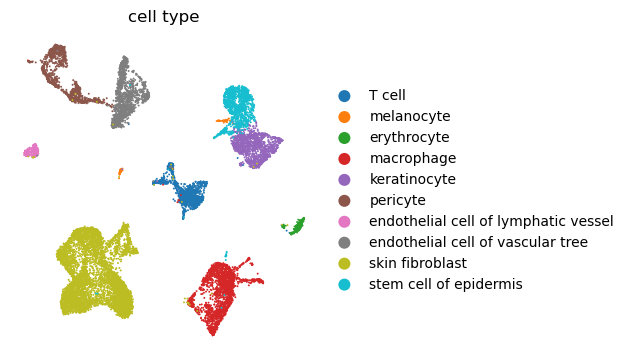

In [65]:
# Plot cell-types for reference (RNA)
sc.pl.scatter(adata, basis='umap', color='cell_type', frameon=False)

In [66]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells


In [67]:
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

# rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(adata, SEACells_label='SEACell')

Welcome to SEACells!


In [68]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/15457 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/15457 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/15457 [00:00<?, ?it/s]

Constructing CSR matrix...


In [69]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 


Done.
Sampling waypoints ...
Done.
Selecting 81 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 19/19 [00:00<00:00, 125.17it/s]

Selecting 9 cells from greedy initialization.


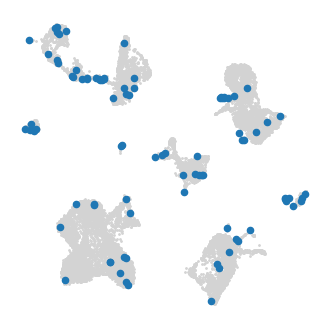

In [70]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata, model)

In [71]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.


Setting convergence threshold at 0.00221
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 29 iterations.


In [72]:
adata

AnnData object with n_obs × n_vars = 15457 × 30867
    obs: 'age', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'donor_id', 'suspension_type', 'Cluster', 'Celltype', 'tissue_type', 'sample_id', 'library_id', 'library_preparation_batch', 'library_sequencing_run', 'alignment_software', 'manner_of_death', 'sample_source', 'sample_collection_method', 'institute', 'sampled_site_condition', 'sample_preservation_method', 'sequenced_fragment', 'reference_genome', 'cell_enrichment', 'gene_annotation_version', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'SEACell'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'cell_type_ontology_term_id_colors', 'citat

In [73]:
adata.obs['SEACell']

index
AAACCTGAGTTAAGTG-1     SEACell-5
AAACCTGTCCATTCTA-1    SEACell-58
AACACGTGTTCCACAA-1     SEACell-5
AACCGCGCACGCGAAA-1    SEACell-55
AACCGCGCACTGAAGG-1     SEACell-5
                         ...    
TTGGAACTCAAGGCTT-5     SEACell-7
TTTACTGTCGGTTAAC-5    SEACell-38
TTTGCGCTCTCGCTTG-5    SEACell-42
TTTGCGCTCTGCTTGC-5    SEACell-42
TTTGTCAGTTCTGGTA-5    SEACell-42
Name: SEACell, Length: 15457, dtype: object

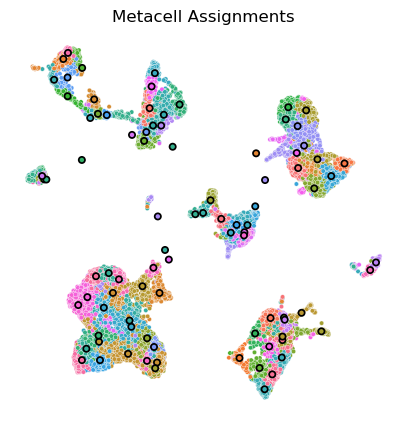

In [74]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=True)

In [ ]:
# export adata to h5ad

processed_folder = "../processed_data/"
adata.write_h5ad(processed_folder + "pbmc10k_SEACells.h5ad", compression='gzip')

In [75]:
from SEACells.core import summarize_by_SEACell

In [17]:
adata.layers['raw'] = adata.layers['raw_data']
# remove the raw_data layer to avoid confusion
adata.layers.pop('raw_data', None)

<10985x14916 sparse matrix of type '<class 'numpy.float32'>'
	with 28326783 stored elements in Compressed Sparse Row format>

In [76]:
ad = summarize_by_SEACell(adata, SEACells_label='SEACell')

100%|██████████| 90/90 [00:00<00:00, 114.46it/s]


In [77]:
# Step 1: Get a mapping from SEACell to the most frequent 'majority_voting' label in adata
majority_map = (
    adata.obs.groupby('SEACell')['cell_type']
    .agg(lambda x: x.value_counts().idxmax())
)

In [78]:
# Step 2: Map this to your smaller ad AnnData object
ad.obs['cell_type'] = ad.obs_names.map(majority_map)

In [79]:
sc.pp.normalize_total(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=2500, inplace=True)

sc.tl.pca(ad, use_highly_variable=True)
sc.pp.neighbors(ad, use_rep='X_pca')
sc.tl.umap(ad)

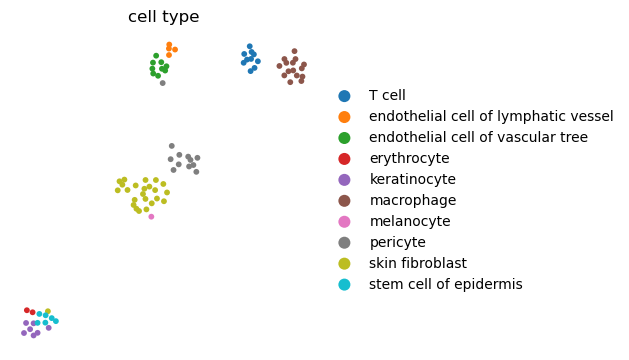

In [80]:
sc.pl.scatter(ad, basis='umap', color='cell_type', frameon=False, size=70)

In [88]:
adata.uns['SEACells_summary'] = ad

In [89]:
# write the processed adata to file
# adata.write_h5ad("../processed_data/pbmc10k_SEACells_summary.h5ad")
adata.write_h5ad("../processed_data/GSE130973_SEACells_summary.h5ad")

### Subsample to test the App

In [ ]:
import scanpy as sc

# Load your full AnnData
adata = sc.read_h5ad("../processed_data/pbmc10k_SEACells.h5ad")

# Subsample 1000 cells (or fewer, adjust as needed)
adata_sub = adata[:1000].copy()

# Optional: Remove layers or obs/cell metadata that are large
if "X" in adata_sub.layers:
    del adata_sub.layers["X"]
adata_sub.raw = None  # Drop raw if unnecessary

# Save smaller version
adata_sub.write("../processed_data/pbmc10k_subset.h5ad", compression="gzip")